### Loading database
`database.yml` and its meta data was created using `make_pyan_database.py`

In [1]:
!PYANNOTE_DATABASE_CONFIG="database.yml" pyannote-database info Primock.SpeakerDiarization.full

'Primock.SpeakerDiarization.full' found in /data/saiakarsh/codes/diar_aug/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'Primock.SpeakerDiarization.full' found in /data/saiakarsh/codes/diar_aug/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
/data/saiakarsh/envs/augnito/lib/python3.9/site-packages/pyannote/database/registry.py:487: UserWarning: Replacing existing Primock.SpeakerDiarization.full protocol by the one defined in '/data/saiakarsh/codes/diar_aug/database.yml'.
  warnings.warn(f"Replacing existing {realname} protocol by the one defined in '{database_yml}'.")
train
   45 files
   6h50m annotated
   6h16m of speech (92%)
   46 speakers
development
   6 files
   0h54m annotated
   0h49m of speech (91%)
   7 speakers
test
   6 files
   0h53m annotated
   0h48m of speech (92%)
   7 speakers


In [2]:
from pyannote.database import registry, FileFinder

registry.load_database("database.yml")
dataset = registry.get_protocol('Primock.SpeakerDiarization.full', preprocessors={"audio": FileFinder()})

'Primock.SpeakerDiarization.full' found in /data/saiakarsh/codes/diar_aug/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'Primock.SpeakerDiarization.full' found in /data/saiakarsh/codes/diar_aug/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.


/data/saiakarsh/envs/augnito/lib/python3.9/site-packages/pyannote/database/registry.py:487: UserWarning: Replacing existing Primock.SpeakerDiarization.full protocol by the one defined in '/data/saiakarsh/codes/diar_aug/database.yml'.
  warnings.warn(f"Replacing existing {realname} protocol by the one defined in '{database_yml}'.")


### Loading pretrained model

In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [4]:
import os
import torch
from tqdm import tqdm
from pyannote.audio import Pipeline

pretrained_pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token=True
)
pretrained_pipeline.to(torch.device("cuda"))

/data/saiakarsh/envs/augnito/lib/python3.9/site-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
/data/saiakarsh/envs/augnito/lib/python3.9/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
torchvision is not available - cannot save figures


### DER eval on pretrained model

In [5]:
from pyannote.metrics.diarization import DiarizationErrorRate
metric = DiarizationErrorRate()

for file in tqdm(dataset.test()):
    file["pretrained pipeline"] = pretrained_pipeline(file)
    metric(file["annotation"], file["pretrained pipeline"], uem=file["annotated"])

print(f"The pretrained pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on {dataset.name} test set.")

6it [05:18, 53.16s/it]

The pretrained pipeline reaches a Diarization Error Rate (DER) of 30.8% on Primock.SpeakerDiarization.full test set.


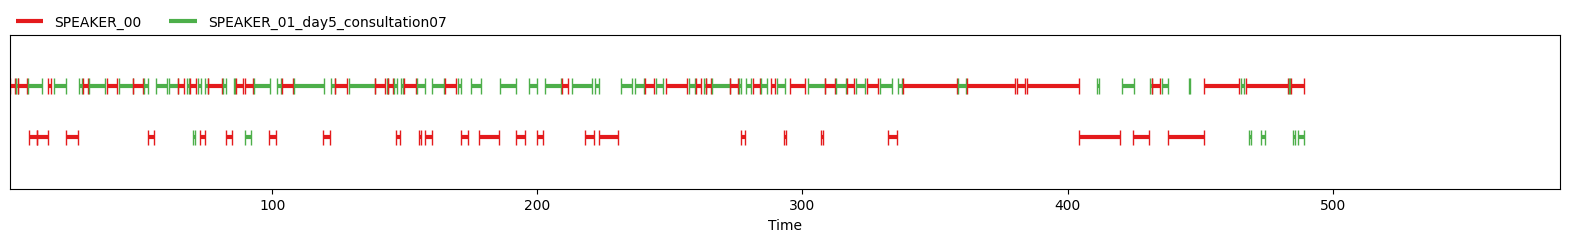

In [11]:
file["annotation"]

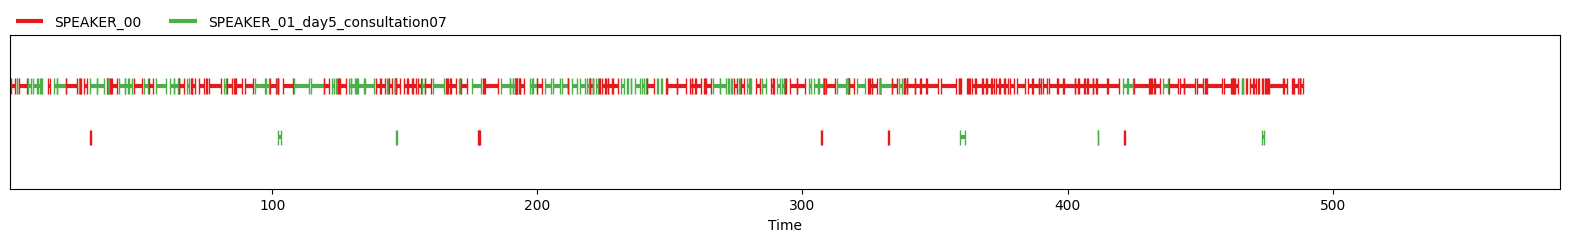

In [12]:
file["pretrained pipeline"]

### Finetuning the segmentation model

In [14]:
from pyannote.audio import Model
model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=True)

In [15]:
from pyannote.audio.tasks import Segmentation
task = Segmentation(
    dataset, 
    duration=model.specifications.duration, 
    max_num_speakers=len(model.specifications.classes), 
    batch_size=32,
    num_workers=2, 
    loss="bce", 
    vad_loss="bce")
model.task = task
model.prepare_data()
model.setup(stage="fit")

Protocol Primock.SpeakerDiarization.full does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


In [16]:
# this takes approximately 15min to run on Google Colab GPU
from types import MethodType
from torch.optim import Adam
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichProgressBar,
)

# we use Adam optimizer with 1e-4 learning rate
def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-4)

model.configure_optimizers = MethodType(configure_optimizers, model)

# we monitor diarization error rate on the validation set
# and use to keep the best checkpoint and stop early
monitor, direction = task.val_monitor
checkpoint = ModelCheckpoint(
    monitor=monitor,
    mode=direction,
    save_top_k=1,
    every_n_epochs=1,
    save_last=False,
    save_weights_only=False,
    filename="{epoch}",
    verbose=False,
)
early_stopping = EarlyStopping(
    monitor=monitor,
    mode=direction,
    min_delta=0.0,
    patience=10,
    strict=True,
    verbose=False,
)

callbacks = [RichProgressBar(), checkpoint, early_stopping]

# we train for at most 20 epochs (might be shorter in case of early stopping)
from pytorch_lightning import Trainer
trainer = Trainer(accelerator="gpu", 
                  callbacks=callbacks, 
                  max_epochs=20,
                  gradient_clip_val=0.5)
trainer.fit(model)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /data/saiakarsh/codes/diar_aug/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name              ┃ Type             ┃ Params ┃       In sizes ┃                                  Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ sincnet           │ SincNet          │ 42.6 K │ [1, 1, 160000] │                               [1, 60, 589] │
│ 1 │ lstm              │ LSTM             │  1.4 M │   [1, 589, 60] │       [[1, 589, 256], [[8, 1, 128], [8, 1, │
│   │                   │                  │        │                │                                     128]]] │
│ 2 │ linear            │ ModuleList       │ 49.4 K │              ? │                                          ? │
│ 3 │ classifier        │ Linear           │    387 │  [1, 589, 128] │                                [1, 589, 3] │
│ 4 │ activation        │ Sigmoid          │      0 │    [1, 589, 3] │                                [1, 589, 3] │
│ 5 │ validation_metric │ MetricCollection │      0 │              ? │                                          ? │
└───┴───────────────────┴──────────────────┴────────┴────────────────┴────────────────────────────────────────────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


In [17]:
finetuned_model = checkpoint.best_model_path
print(finetuned_model)
pretrained_hyperparameters = pretrained_pipeline.parameters(instantiated=True)
print(pretrained_hyperparameters)

/data/saiakarsh/codes/diar_aug/lightning_logs/version_0/checkpoints/epoch=19.ckpt
{'segmentation': {'min_duration_off': 0.0}, 'clustering': {'method': 'centroid', 'min_cluster_size': 12, 'threshold': 0.7045654963945799}}


### Optimizing the pipeline hyper-parameters

In [18]:
from pyannote.audio.pipelines import SpeakerDiarization
from pyannote.pipeline import Optimizer

pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    clustering="OracleClustering",  
)
pipeline.freeze({"segmentation": {"min_duration_off": 0.0}})

optimizer = Optimizer(pipeline)
dev_set = list(dataset.development())

iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best segmentation threshold so far: {iteration['params']['segmentation']['threshold']}")
    if i > 20: break   # 50 iterations should give slightly better results

best_segmentation_threshold = optimizer.best_params["segmentation"]["threshold"]

Best segmentation threshold so far: 0.2179975838414812
Best segmentation threshold so far: 0.8059579225660737
Best segmentation threshold so far: 0.8059579225660737
Best segmentation threshold so far: 0.8059579225660737
Best segmentation threshold so far: 0.8059579225660737
Best segmentation threshold so far: 0.6794543670023232
Best segmentation threshold so far: 0.6794543670023232
Best segmentation threshold so far: 0.6794543670023232
Best segmentation threshold so far: 0.6794543670023232
Best segmentation threshold so far: 0.6794543670023232
Best segmentation threshold so far: 0.6794543670023232
Best segmentation threshold so far: 0.6794543670023232
Best segmentation threshold so far: 0.5766626828197758
Best segmentation threshold so far: 0.5766626828197758
Best segmentation threshold so far: 0.5766626828197758
Best segmentation threshold so far: 0.5766626828197758
Best segmentation threshold so far: 0.5766626828197758
Best segmentation threshold so far: 0.5694551178384555
Best segme

In [19]:
pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
)

pipeline.freeze({
    "segmentation": {
        "threshold": best_segmentation_threshold,
        "min_duration_off": 0.0,
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
    },
})

optimizer = Optimizer(pipeline)
iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best clustering threshold so far: {iteration['params']['clustering']['threshold']}")
    if i > 20: break  # 50 iterations should give slightly better results

best_clustering_threshold = optimizer.best_params['clustering']['threshold']

Best clustering threshold so far: 0.20657516412203258
Best clustering threshold so far: 0.20657516412203258
Best clustering threshold so far: 0.4601952391886195
Best clustering threshold so far: 0.4601952391886195
Best clustering threshold so far: 0.4717281633654751
Best clustering threshold so far: 0.4717281633654751
Best clustering threshold so far: 0.7995650252252342
Best clustering threshold so far: 0.7995650252252342
Best clustering threshold so far: 0.7995650252252342
Best clustering threshold so far: 0.7995650252252342
Best clustering threshold so far: 0.7995650252252342
Best clustering threshold so far: 0.7995650252252342
Best clustering threshold so far: 0.7995650252252342
Best clustering threshold so far: 0.7995650252252342
Best clustering threshold so far: 0.7995650252252342
Best clustering threshold so far: 0.7995650252252342
Best clustering threshold so far: 0.7995650252252342
Best clustering threshold so far: 0.7995650252252342
Best clustering threshold so far: 0.79956502

### Speaker Diarization using finetuned pipeline

In [20]:
finetuned_pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
)

finetuned_pipeline.instantiate({
    "segmentation": {
        "threshold": best_segmentation_threshold,
        "min_duration_off": 0.0,
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
        "threshold": best_clustering_threshold,
    },
})

print(best_segmentation_threshold, best_clustering_threshold)

0.5952774382125149 0.7995650252252342


### DER eval on finetuned model

In [21]:
metric = DiarizationErrorRate()

for file in tqdm(dataset.test()):
    file["finetuned pipeline"] = finetuned_pipeline(file)
    metric(file["annotation"], file["finetuned pipeline"], uem=file["annotated"])

print(f"The finetuned pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on {dataset.name} test set.")

0it [01:56, ?it/s]

The finetuned pipeline reaches a Diarization Error Rate (DER) of 8.0% on Primock.SpeakerDiarization.full test set.


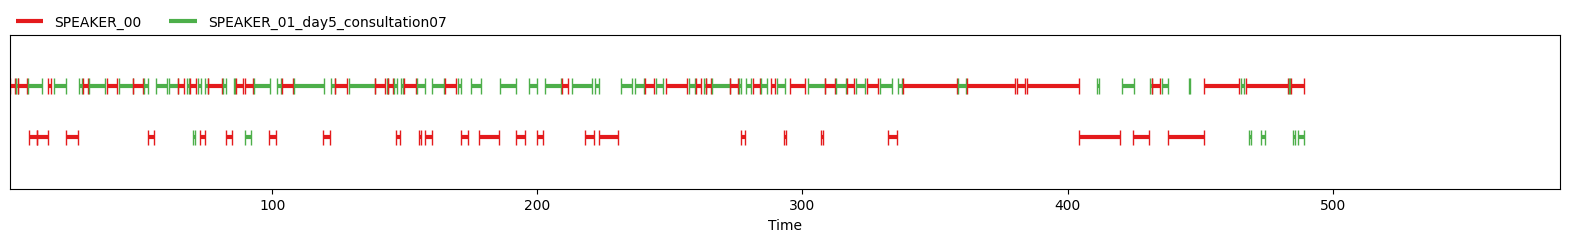

In [22]:
file["annotation"]

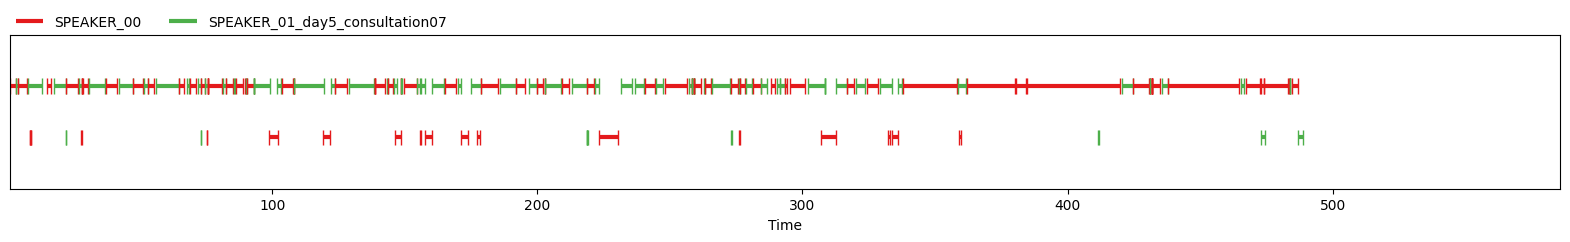

In [23]:
file["finetuned pipeline"]